# Identification Of Cell Nuclei by Semantic Segmentation

Task: Create a model for **semantic segmentation** for images containing cell nuclei.

Criteria:
- Try to achieve **training and validation** accuracy more than 80%
- Not overfitting
- **Build an U-Net** for this project:
    - Downsampling path - can apply transfer learning.
    - Then, build your own upsampling path similarily as what we did in the exercise
- For model deployment, try to use the model to make some predictions with your test data.

In [1]:
# 1. Import packages

import os
import random
import datetime

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from skimage.transform import resize
from skimage.io import imread, imshow


2024-11-11 15:46:09.672029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 15:46:09.684917: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-11 15:46:09.689310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 15:46:09.700475: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-11 15:46:10.350356: W tensorflow/compiler/tf2

In [2]:
# 2. Data Loading

# Train and Test Pathes

TRAIN_PATH = 'Dataset/train/'
TEST_PATH = 'Dataset/test/'

In [3]:
# Create train and test images pathes

TRAIN_PATH_IMAGES = 'Dataset/train/inputs/'
TEST_PATH_IMAGES = 'Dataset/test/inputs/'

# X_train, X_test --> images

# total of train images

count = 0

for path in os.scandir(TRAIN_PATH_IMAGES):
    if path.is_file():
        count = count + 1

print(count)

603


In [4]:
# Resizing training and testing images

# -- Constants --

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# a. Load train images from inputs subfolder

from skimage.io import imread_collection

train_images_dir = os.path.join(TRAIN_PATH_IMAGES, '*.png')
train_images = imread_collection(train_images_dir)

# Print the number of train images
print(len(train_images))

603


In [5]:
# b. Load test images from inputs subfolder

test_images_dir = os.path.join(TEST_PATH_IMAGES, '*.png')
test_images = imread_collection(test_images_dir)

# Print the number of test images
print(len(test_images))

67


In [6]:
# c. Resizing (part 1: Train images).

X_train = np.zeros((len(train_images), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

# Testing the iteration through image files from inputs subfolder.
# This will list down all image file on subfolder.
# for n in os.listdir(TRAIN_PATH_IMAGES):
    # print(n)

from PIL import Image

index_trainimg = 0 # Tracking the number of resized images filled into X_train

for i in os.listdir(TRAIN_PATH_IMAGES):
    if os.path.isfile(TRAIN_PATH_IMAGES + i):
        image = Image.open(TRAIN_PATH_IMAGES + i)
        image = image.resize((IMG_WIDTH, IMG_HEIGHT))

        image = np.array(image)[:,:,:IMG_CHANNELS]

        # Fill resized images into the X_train
        X_train[index_trainimg] = image
        index_trainimg += 1

# Total number of resized images filled into X_train
print(index_trainimg)

603


In [7]:
# d. Resizing (part 2: Test images)

X_test = np.zeros((len(test_images), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

index_testimg = 0

for i in os.listdir(TEST_PATH_IMAGES):
    if os.path.isfile(TEST_PATH_IMAGES + i):
        image = Image.open(TEST_PATH_IMAGES + i)
        image = image.resize((IMG_WIDTH, IMG_HEIGHT))

        image = np.array(image)[:,:,:IMG_CHANNELS]

        # Fill resized images into the X_test
        X_test[index_testimg] = image
        index_testimg += 1

print(index_testimg)

67


In [8]:
# Create train and test masks pathes

TRAIN_PATH_MASKS = 'Dataset/train/masks/'
TEST_PATH_MASKS = 'Dataset/test/masks/'

# y_train, y_test --> masks

In [9]:
# Load train masks from masks subfolder

train_masks_dir = os.path.join(TRAIN_PATH_MASKS, '*.png')
train_masks = imread_collection(train_masks_dir)

# Print the number of train masks
print(len(train_masks))

603


In [10]:
# Load test masks from masks subfolder

test_masks_dir = os.path.join(TEST_PATH_MASKS, '*.png')
test_masks = imread_collection(test_masks_dir)

# Print the number of test images
print(len(test_masks))

67


In [11]:
# Resizing masks (Part 1: Train masks)

y_train = np.zeros((len(train_masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

index_trainmask = 0

for j in os.listdir(TRAIN_PATH_MASKS):
    if os.path.isfile(TRAIN_PATH_MASKS + j):
        mask = Image.open(TRAIN_PATH_MASKS + j)
        mask = mask.resize((IMG_WIDTH, IMG_HEIGHT))
        mask = np.array(mask)
        mask = np.expand_dims(mask, axis=-1)
        y_train[index_trainmask] = mask
        index_trainmask += 1

print(index_trainmask)

603


In [12]:
# Resizing masks (Part 2: Test masks)

y_test = np.zeros((len(test_masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

index_testmask = 0

for j in os.listdir(TEST_PATH_MASKS):
    if os.path.isfile(TEST_PATH_MASKS + j):
        mask = Image.open(TEST_PATH_MASKS + j)
        mask = mask.resize((IMG_WIDTH, IMG_HEIGHT))
        mask = np.array(mask)
        mask = np.expand_dims(mask, axis=-1)
        y_train[index_testmask] = mask
        index_testmask += 1

print(index_testmask)

67


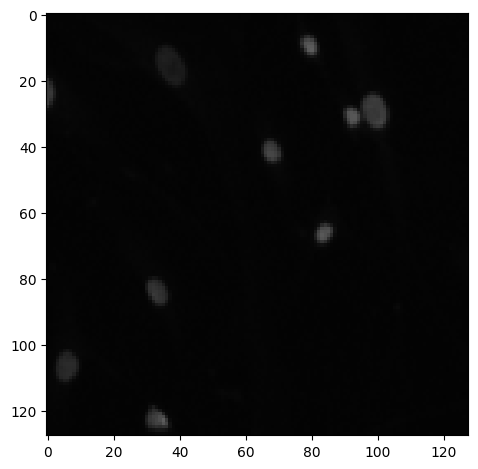

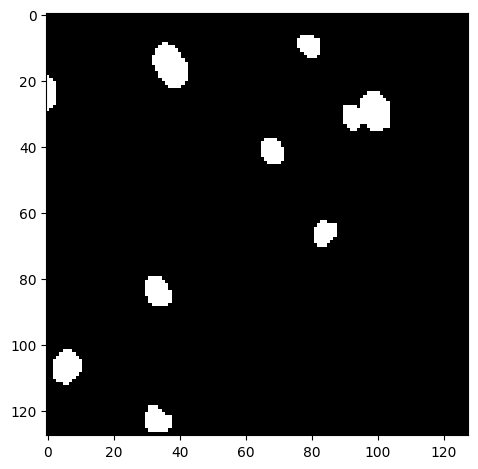

In [13]:
# 3. Check if our training data and the segmented images related or not?

image_x=random.randint(0,len(train_images))

imshow(X_train[image_x])
plt.show()

imshow(np.squeeze(y_train[image_x]))
plt.show()

# Yes, it's related

In [14]:
# 4. Model Development For Semantic Segmentation - U-Net

# a. Get the pre-trained model as feature extractor

base_model = keras.applications.MobileNetV2(input_shape=[IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS], include_top=False)
base_model.summary()

I0000 00:00:1731311176.094311   30848 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731311176.115032   30848 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731311176.116246   30848 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731311176.118221   30848 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [15]:
# b. Use these activation layers as the outputs of the feature extractor

# Use the activations of these layers

layer_names = [
    'block_1_expand_relu', # 64x64
    'block_3_expand_relu', # 32x32
    'block_6_expand_relu', # 16x16
    'block_13_expand_relu', # 8x8
    'block_16_project', # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extractor model that will connect to the upsampling path later
down_stack = keras.Model(inputs=base_model.input,outputs=base_model_outputs)
# Freeze the feature extractor
down_stack.trainable = False

In [16]:
# c. Create the upsampling layers


from tensorflow_examples.models.pix2pix import pix2pix

# To install this module, just type:
# pip install -q git+https://github.com/tensorflow/examples.git

# Create the upsampling layers
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

up_stack[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
# d. Create a function to help construct the UNet model

def unet_model(output_channels:int):
    # Use functional API to build the entire model

    # i. Start with input
    inputs = keras.layers.Input(shape=[IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS])

    # ii. Followed by the feature extractor
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # iii. Build the upsampling path by concatenating with the outputs from feature extractor, along with using the upsampling layers
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = keras.layers.Concatenate()
        x = concat([x, skip])
    
    # iv. Construct the last layer, which will be a transpose convolution layer
    last = keras.layers.Conv2DTranspose(filters=output_channels,kernel_size=3,strides=2,padding='same')  # 64x64 --> 128x128

    x = last(x)

    model = keras.Model(inputs=inputs,outputs=x)
    return model

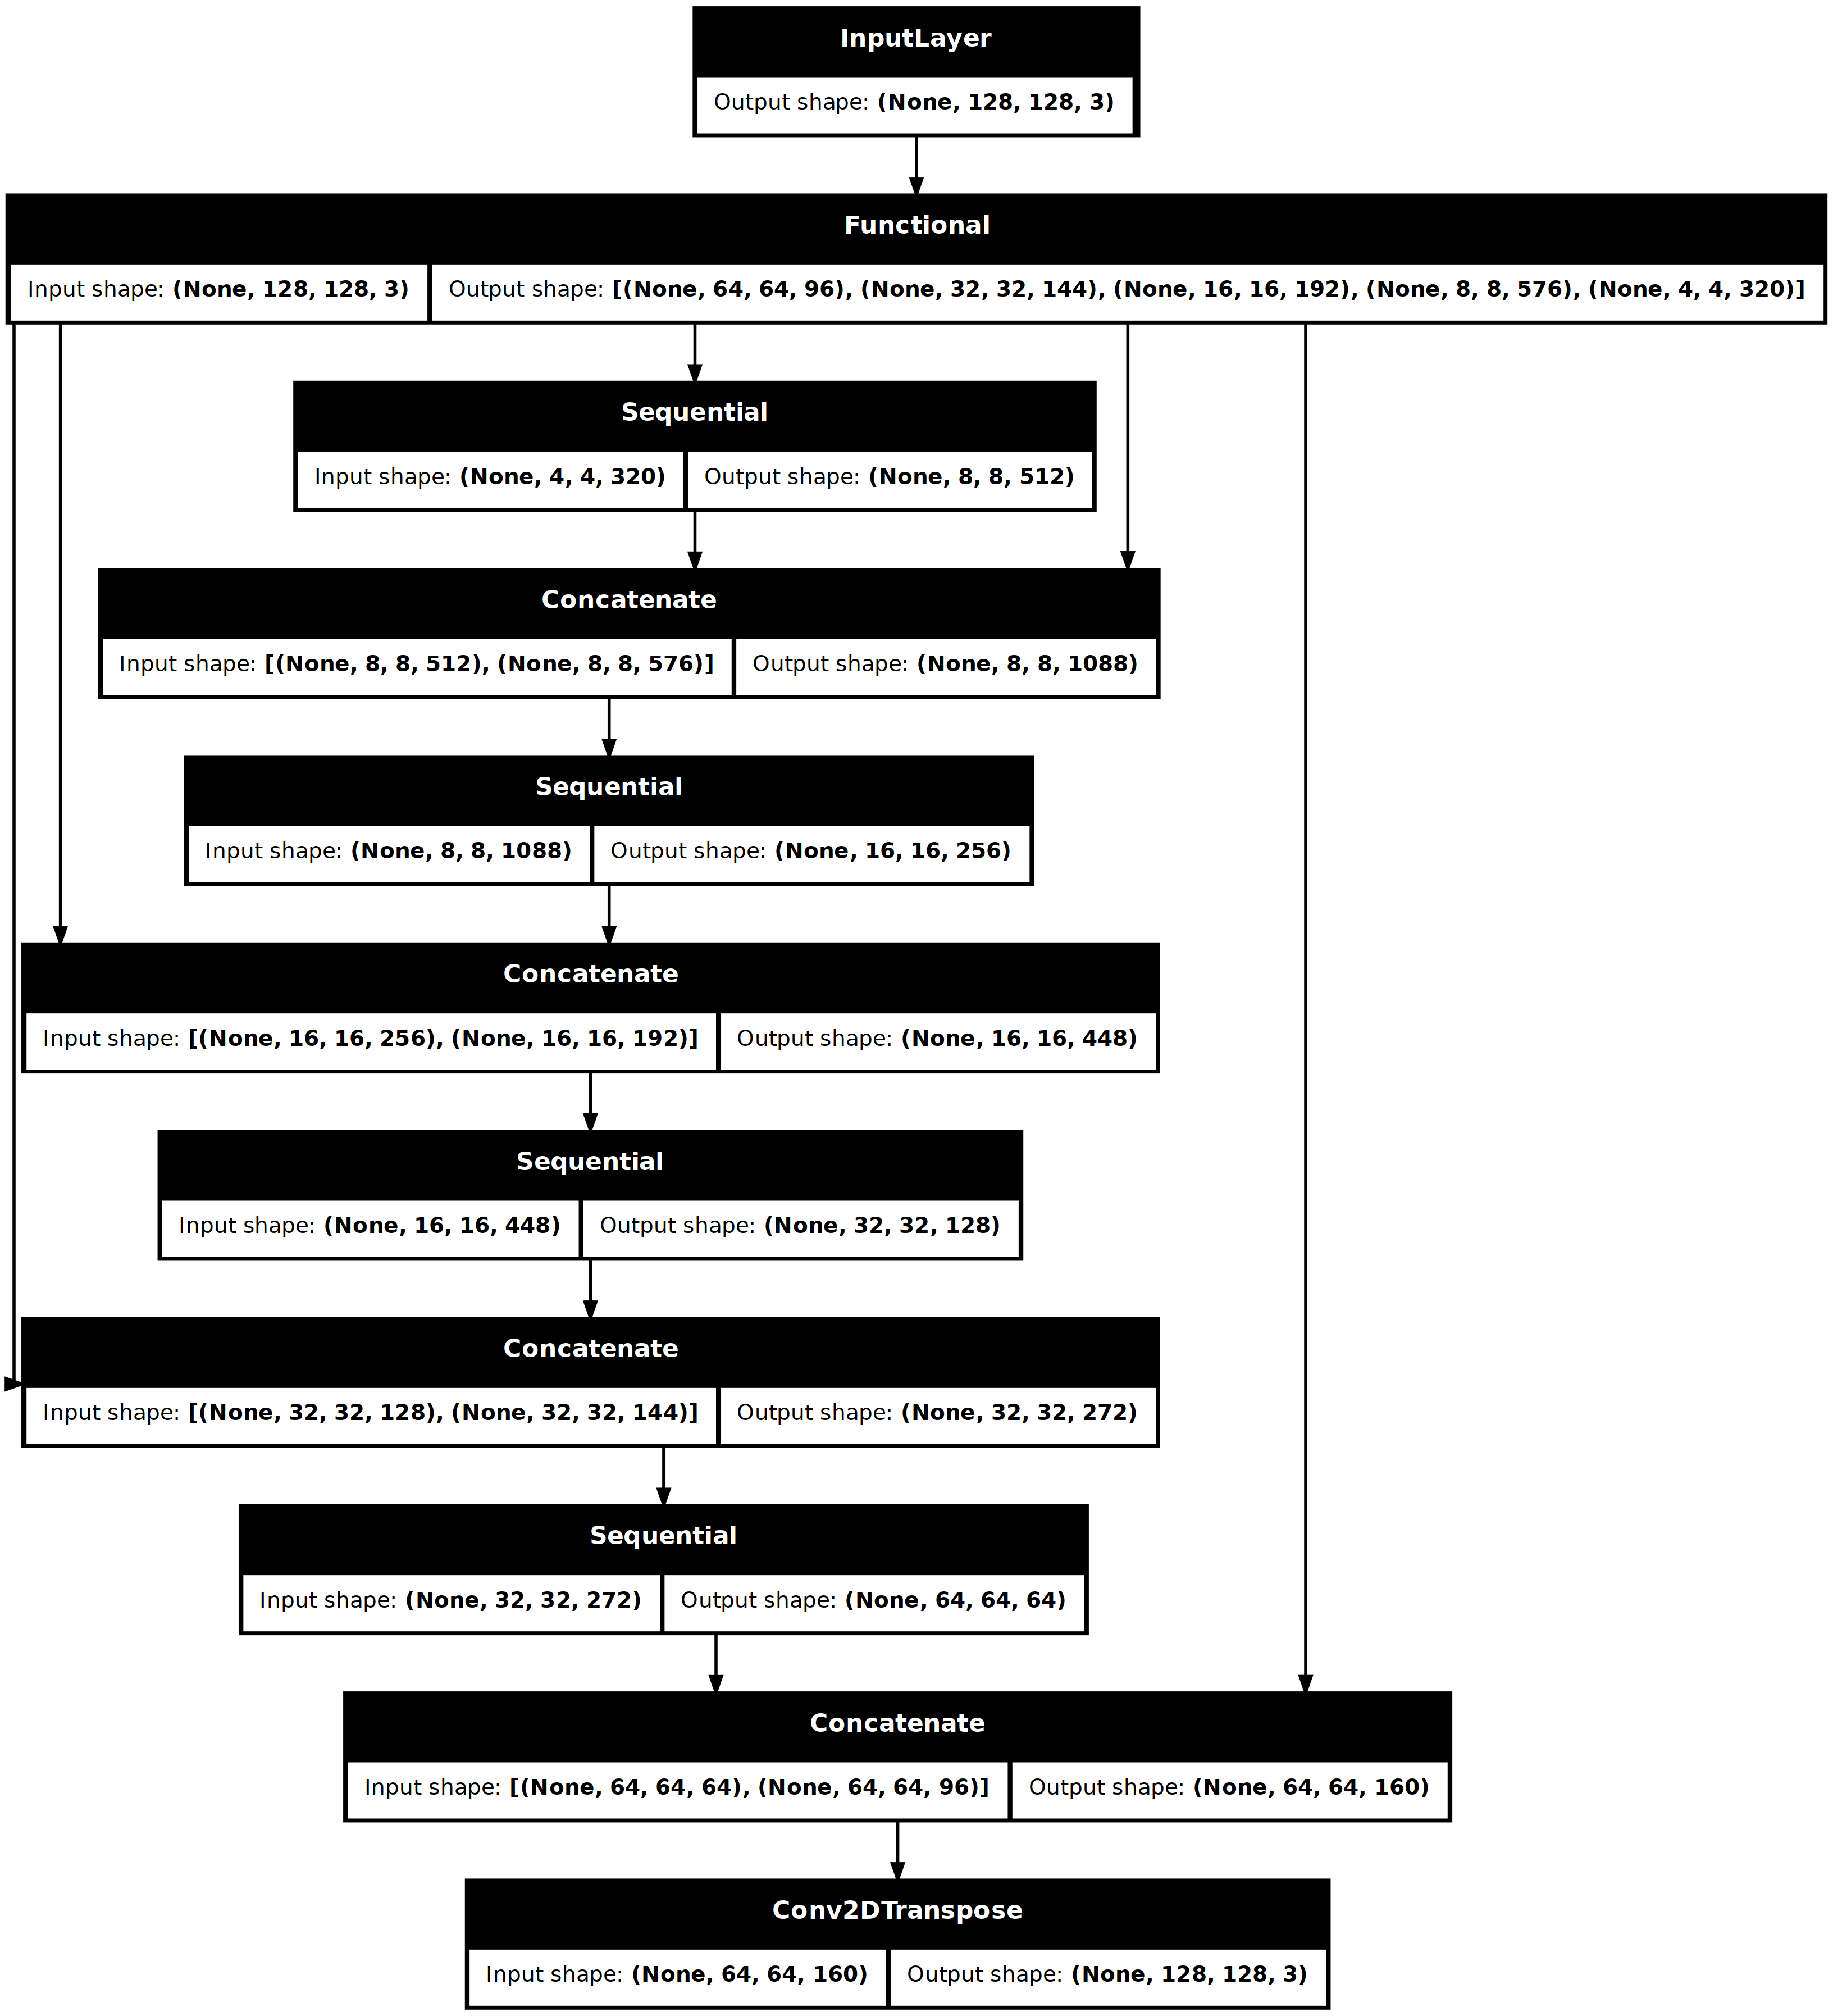

In [18]:
# e. Use the function to create the UNet model

model = unet_model(3)

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',loss=loss,metrics=['accuracy'])
keras.utils.plot_model(model,show_shapes=True)

In [19]:
# 5. Model Training

logpath = "tensorboard/segmentation_unet/" + datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")

tb = keras.callbacks.TensorBoard(logpath)
es = keras.callbacks.EarlyStopping(patience=3, verbose=1)

In [20]:
# Train the model

result = model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=50, callbacks=[tb, es])

Epoch 1/50


I0000 00:00:1731311182.020474   31151 service.cc:146] XLA service 0x181b2d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731311182.020489   31151 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-11-11 15:46:22.143328: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1731311182.501068   31151 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-11-11 15:46:22.729122: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0957 - loss: 2.1202 

I0000 00:00:1731311191.962483   31151 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4327 - loss: 1.3206

W0000 00:00:1731311193.037553   31151 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.4467 - loss: 1.2899

W0000 00:00:1731311199.919605   31153 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1731311201.045444   31153 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 929ms/step - accuracy: 0.4589 - loss: 1.2628 - val_accuracy: 0.8620 - val_loss: 0.3485
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8479 - loss: 0.3634 - val_accuracy: 0.8970 - val_loss: 0.2381
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8697 - loss: 0.3236 - val_accuracy: 0.9077 - val_loss: 0.2059
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8877 - loss: 0.2943 - val_accuracy: 0.9068 - val_loss: 0.1996
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8917 - loss: 0.2737 - val_accuracy: 0.8983 - val_loss: 0.2111
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8976 - loss: 0.2604 - val_accuracy: 0.9126 - val_loss: 0.1882
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8994 - loss: 0.2744 - val_accuracy: 0.9075 - val_loss: 0.1959
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9029 - loss: 0.2602 - val_accuracy: 0.8948 - val_loss: 

In [21]:
# Evaluate the training model

model.evaluate(X_train, y_train)

# Evaluation = [loss, accuracy]

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8630 - loss: 0.3703

W0000 00:00:1731311221.101175   31154 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - accuracy: 0.8722 - loss: 0.3429


[0.2302478700876236, 0.9102871417999268]

In [22]:
# 6. Test the model - Applying the model on the test images

# a. Run the prediction
model_test = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


In [23]:
# b. Evaluation and Classification Reports

# i. Evaluation
model.evaluate(X_test, y_test)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8656 - loss: 0.2818

W0000 00:00:1731311232.687998   31151 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step - accuracy: 0.8663 - loss: 0.2856


[0.2884296476840973, 0.8659995794296265]

In [24]:
# ii. Classification Reports

import sklearn.metrics
from sklearn.metrics import classification_report

prediction = model.predict(X_test)
prediction_index = np.argmax(prediction, axis = -1)

y_test = y_test.flatten()
prediction = prediction_index.flatten()

model_report = classification_report(y_test, prediction, zero_division=0)

print(model_report)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
              precision    recall  f1-score   support

           0       1.00      0.87      0.93   1097728
           1       0.00      0.00      0.00         0

    accuracy                           0.87   1097728
   macro avg       0.50      0.43      0.46   1097728
weighted avg       1.00      0.87      0.93   1097728



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


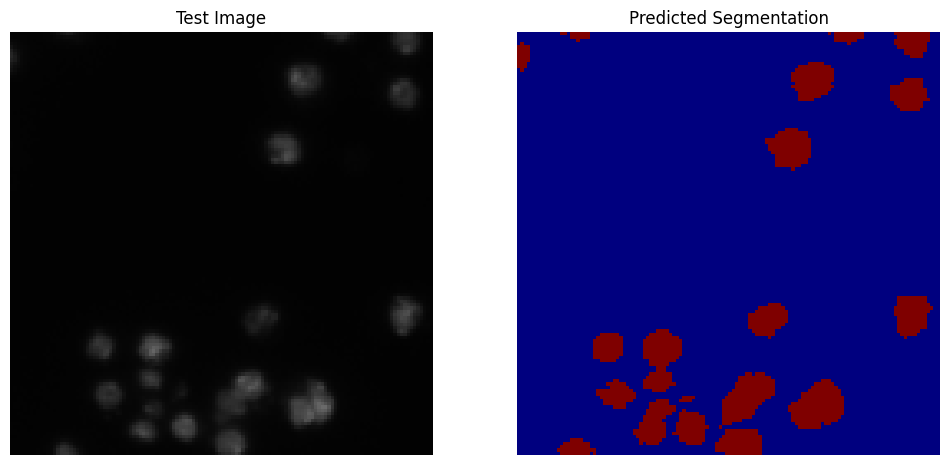

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


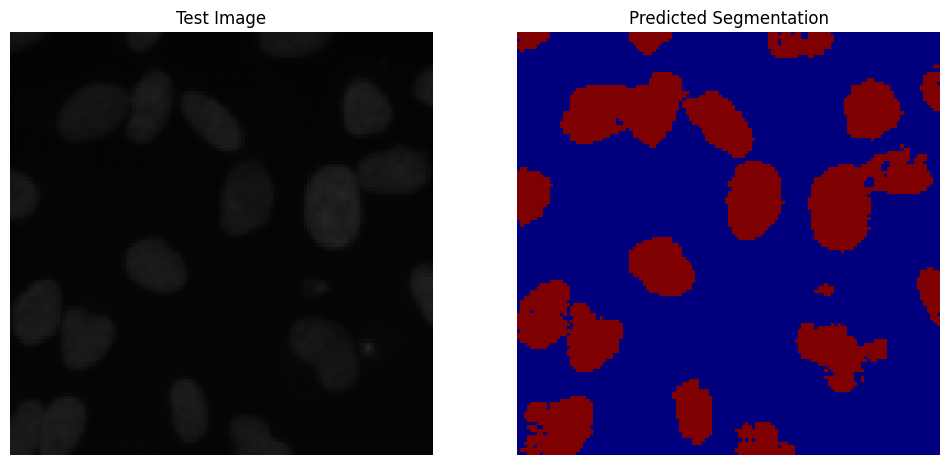

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


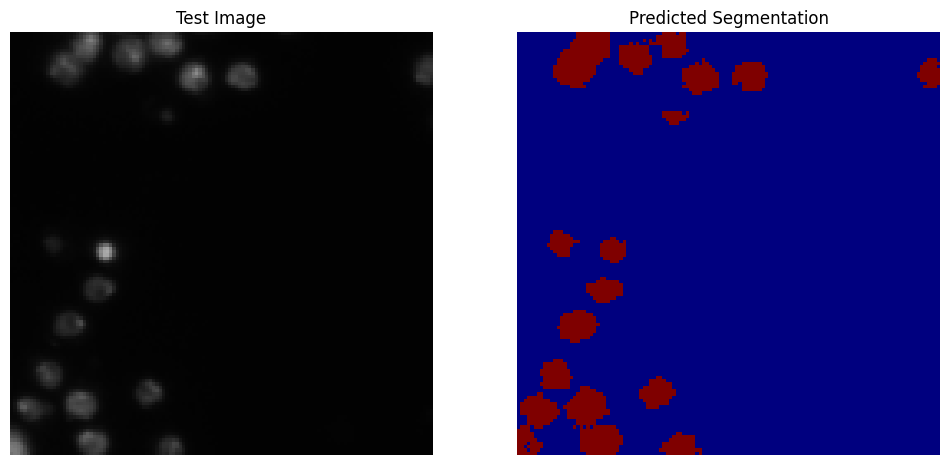

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


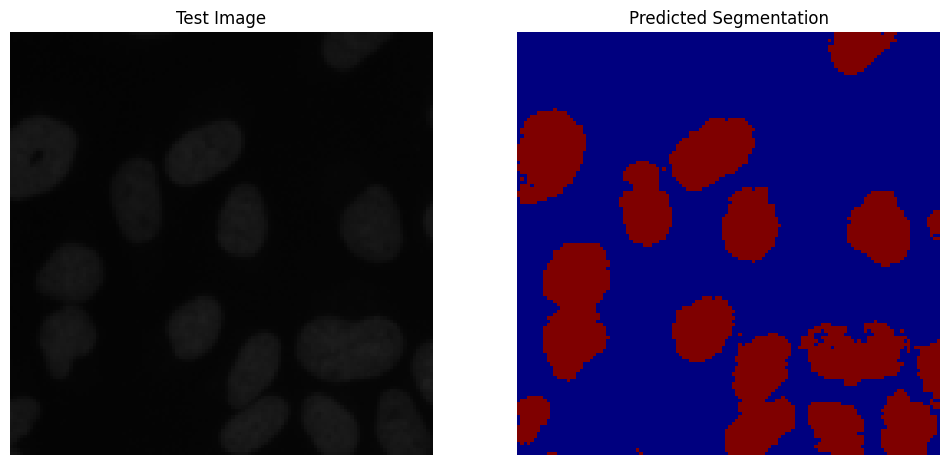

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


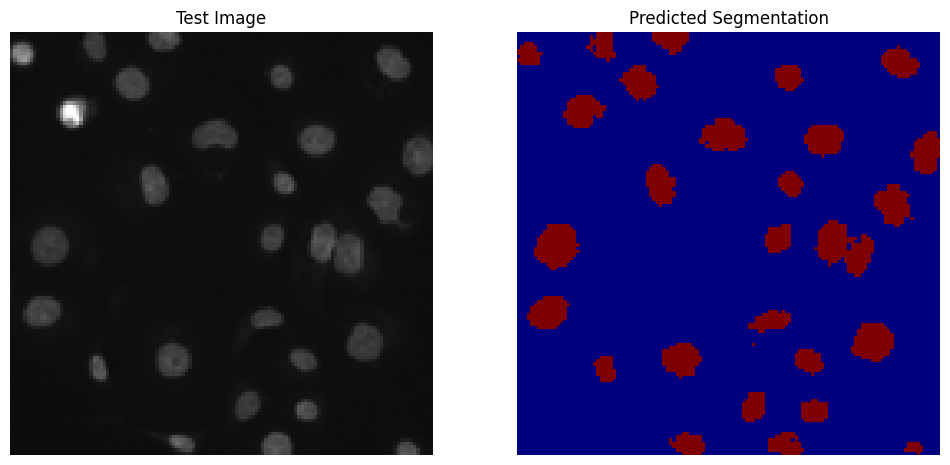

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


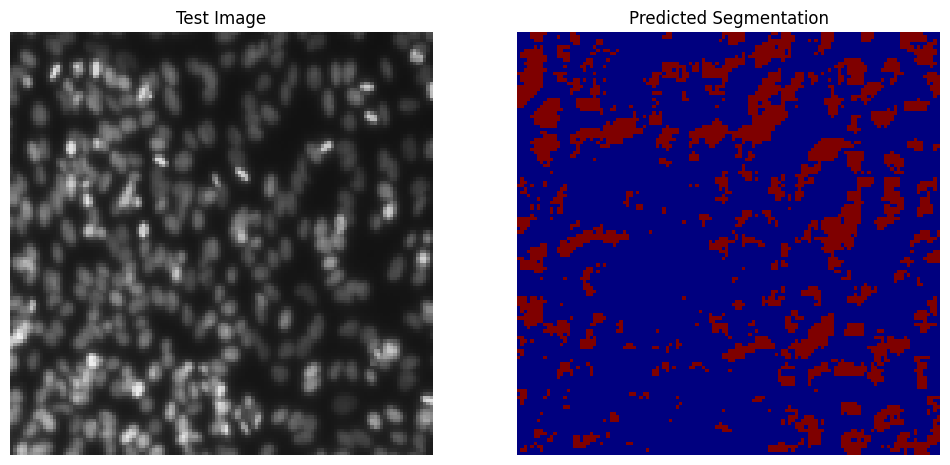

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


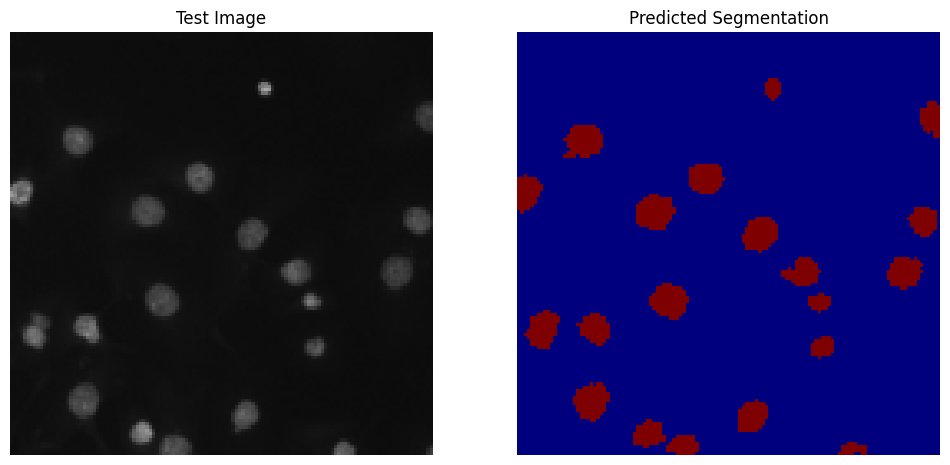

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


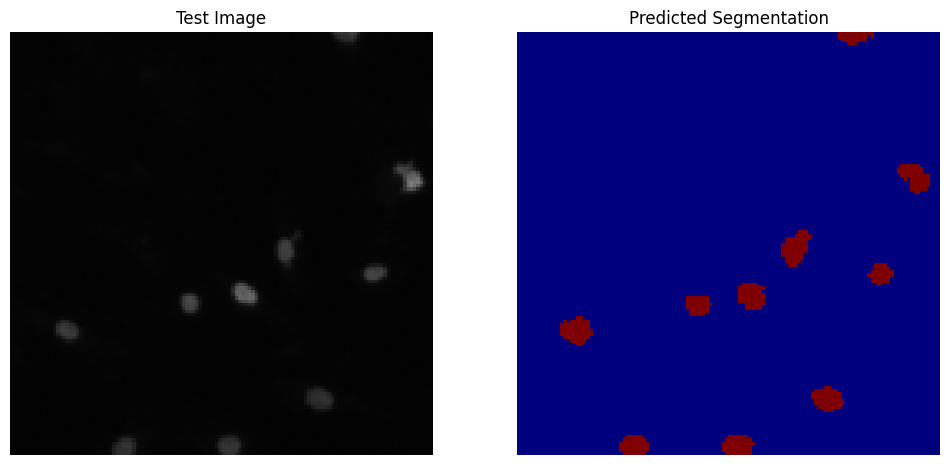

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


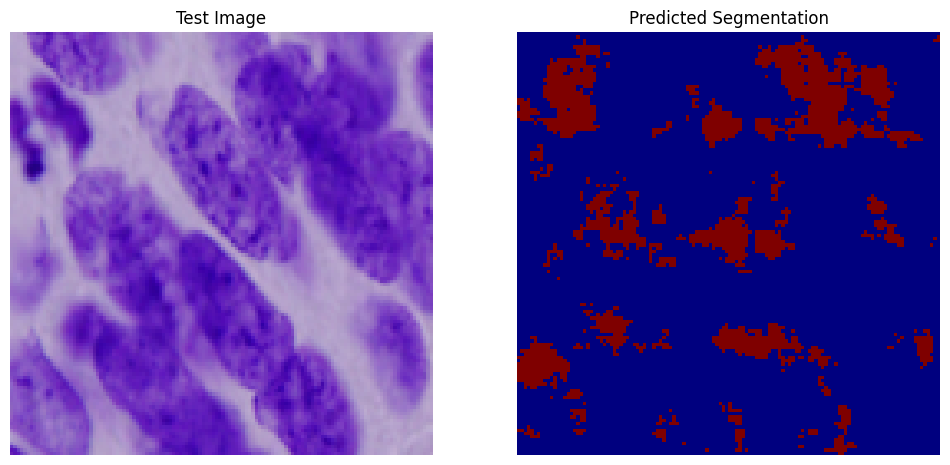

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


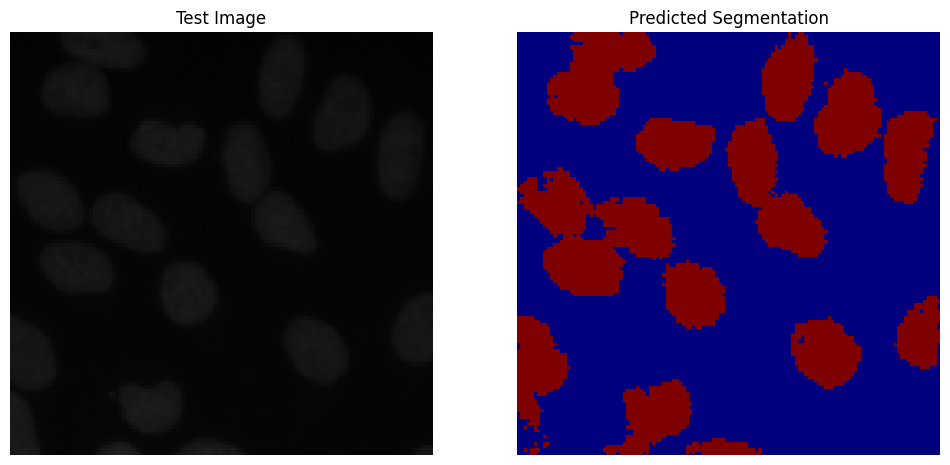

In [25]:
# 7. Plotting the prediction

# First images
for k in range(0,10):
    images_test = X_test[k]

    if images_test.ndim == 2:
        images_test = images_test[..., np.newaxis]

    prediction = model.predict(np.expand_dims(images_test, axis=0))
    predicted_mask = np.argmax(prediction[0], axis=-1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(images_test.squeeze())
    plt.title("Test Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='jet')
    plt.title("Predicted Segmentation")
    plt.axis('off')

    plt.show()

In [26]:
# 8. Save the model

keras.models.save_model(model, "saved_models/Segmentation.h5")